## Configuraciones e installs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 91.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 103.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.1 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=935f431dba200855458e6ebc63fb23f8f39ac90e8646034b0c614ecd34b82438
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 12.8 MB/s eta 0:00:00


## Exploracion de los datos

### Datos DEV

In [ ]:
import pandas as pd
import numpy as np
from datasets import Dataset
import matplotlib.pyplot as plt
import csv
from sklearn.model_selection import train_test_split

In [ ]:
from datasets import load_dataset
from sentence_transformers import SentenceTransformer, LoggingHandler, losses, models, util
from sentence_transformers.readers import InputExample
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator

from transformers                     import AutoModelForMaskedLM
from transformers                     import AutoTokenizer

from torch.utils.data                 import DataLoader
from sklearn.metrics.pairwise         import paired_cosine_distances

from SubTask2Evaluator import evaluate_submission

import torch
from tqdm import tqdm
import os
import time
import datetime
import random
import math
import re

In [ ]:
dev = pd.read_csv("/content/drive/MyDrive/proyecto-final-ecd/datasets/subtask-b/dev.csv")
dev_gold = pd.read_csv("/content/drive/MyDrive/proyecto-final-ecd/datasets/subtask-b/dev.gold.csv")
dev_data = dev.merge(dev_gold[["ID", "sim"]], on="ID", how="inner")


In [ ]:
dev_data.head()

,ID,Language,MWE1,MWE2,sentence1,sentence2,sim
0,83910,EN,high life,None,Are these interruptions of the good life a nec...,Are these interruptions of the good life a nec...,1.0
1,14692,EN,high life,None,But for Australian fashion designer Abby Kheir...,But for Australian fashion designer Abby Kheir...,1.0
2,3378,EN,high life,None,"With that, I will be enjoying the pleasures of...","With that, I will be enjoying the pleasures of...",1.0
3,97296,EN,high life,None,"Fendi offered swaddling, belted coats resembli...","Fendi offered swaddling, belted coats resembli...",1.0
4,36148,EN,high life,None,"Rick Ross and Diddy exemplify the high life, t...",Rick Ross and Diddy exemplify the expensive li...,1.0


In [ ]:
dev_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1775 entries, 0 to 1774
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         1775 non-null   int64  
 1   Language   1775 non-null   object 
 2   MWE1       1775 non-null   object 
 3   MWE2       1775 non-null   object 
 4   sentence1  1775 non-null   object 
 5   sentence2  1775 non-null   object 
 6   sim        1369 non-null   float64
dtypes: float64(1), int64(1), object(5)
memory usage: 110.9+ KB


In [ ]:
dev_data = dev_data.astype({"Language": "string", "sentence1": "string", "sentence2": "string", "MWE1": "string", "MWE2": "string"})
dev_data = dev_data[dev_data["Language"] == "EN"]

In [ ]:
dev_data["Language"].value_counts()

EN    921
Name: Language, dtype: Int64

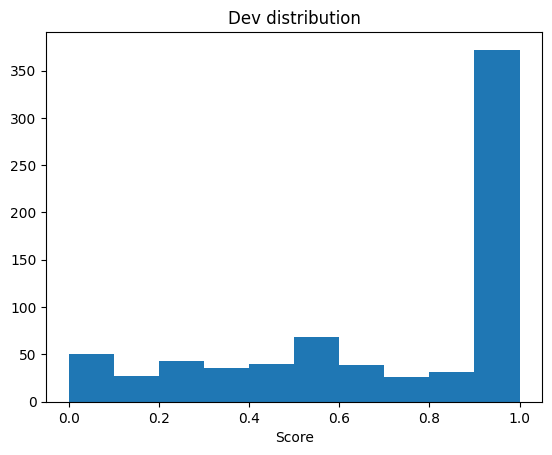

In [ ]:
# Distribucion de datos de dev
plt.hist(dev_data["sim"], bins=10)
plt.xlabel("Score")
plt.title("Dev distribution")
plt.show()

### Datos EVAL

In [ ]:
eval = pd.read_csv("/content/drive/MyDrive/proyecto-final-ecd/datasets/subtask-b/eval.csv")
eval.head()

,ID,Language,MWE1,MWE2,sentence1,sentence2
0,44474,EN,mailing list,None,The Secretary of State’s office became aware o...,The Secretary of State’s office became aware o...
1,84352,EN,mailing list,None,Organizations and individuals may rent the AAF...,Organizations and individuals may rent the AAF...
2,23049,EN,mailing list,None,TDHCA will be providing updates on how to appl...,TDHCA will be providing updates on how to appl...
3,89842,EN,mailing list,None,All major Linux distributions also received th...,All major Linux distributions also received th...
4,60999,EN,mailing list,None,"Larger and active mailing lists (e.g., more th...","Larger and active address lists (e.g., more th..."


In [ ]:
eval.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2262 entries, 0 to 2261
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         2262 non-null   int64 
 1   Language   2262 non-null   object
 2   MWE1       2262 non-null   object
 3   MWE2       2262 non-null   object
 4   sentence1  2262 non-null   object
 5   sentence2  2262 non-null   object
dtypes: int64(1), object(5)
memory usage: 106.2+ KB


In [ ]:
eval = eval.astype({"Language": "string", "sentence1": "string", "sentence2": "string", "MWE1": "string", "MWE2": "string"})
eval = eval[eval["Language"] == "EN"]

In [ ]:
eval["Language"].value_counts()

EN    1180
Name: Language, dtype: Int64

## Datos Benchmark

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/proyecto-final-ecd/datasets/subtask-b/stsbenchmark.tsv", sep='\t', on_bad_lines="warn", quoting=csv.QUOTE_NONE)
data.head()

,split,genre,dataset,year,sid,score,sentence1,sentence2
0,train,main-captions,MSRvid,2012test,1,5.00,A plane is taking off.,An air plane is taking off.
1,train,main-captions,MSRvid,2012test,4,3.80,A man is playing a large flute.,A man is playing a flute.
2,train,main-captions,MSRvid,2012test,5,3.80,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...
3,train,main-captions,MSRvid,2012test,6,2.60,Three men are playing chess.,Two men are playing chess.
4,train,main-captions,MSRvid,2012test,9,4.25,A man is playing the cello.,A man seated is playing the cello.


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8628 entries, 0 to 8627
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   split      8628 non-null   object 
 1   genre      8628 non-null   object 
 2   dataset    8628 non-null   object 
 3   year       8628 non-null   object 
 4   sid        8628 non-null   int64  
 5   score      8628 non-null   float64
 6   sentence1  8628 non-null   object 
 7   sentence2  8628 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 539.4+ KB


In [ ]:
data = data.astype({"split": "string", "score": "float64", "sentence1": "string", "sentence2": "string"})
print(f"Minimo score: {data['score'].min()}. Maximo score: {data['score'].max()}.")

Minimo score: 0.0. Maximo score: 5.0.


In [ ]:
# Me quedo solo con datos de train como dice el enunciado
data_train = data[data["split"] == "train"]
# Mantengo solo columnas relevantes
data_train = data_train[["score", "sentence1", "sentence2"]]
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5749 entries, 0 to 5748
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   score      5749 non-null   float64
 1   sentence1  5749 non-null   string 
 2   sentence2  5749 non-null   string 
dtypes: float64(1), string(2)
memory usage: 179.7 KB


In [ ]:
# Normalizo los scores
data_train["score"] = data_train["score"]/5
print(f"Minimo score normalizado: {data_train['score'].min()}. Maximo score normalizado: {data_train['score'].max()}.")

Minimo score normalizado: 0.0. Maximo score normalizado: 1.0.


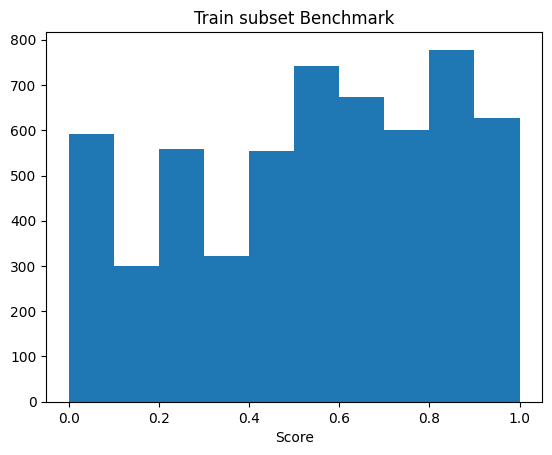

In [ ]:
# Distribucion de datos de Benchmark
plt.hist(data_train["score"], bins=10)
plt.xlabel("Score")
plt.title("Train subset Benchmark")
plt.show()

### Split en Train, Test, y Eval (para entrenar)

In [ ]:
data_train, data_val = train_test_split(data_train, test_size=0.3)
data_train.shape

(4024, 3)

In [ ]:
data_val, data_test = train_test_split(data_val, test_size=0.5)
data_test.shape

(863, 3)

In [ ]:
data_train.head()

,score,sentence1,sentence2
1621,0.44,Two large black dogs are playing in a grassy f...,Two white dogs are running together.
3825,0.96,6.6 quake rocks Indonesia's Papua: USGS,6.6 quake rocks Indonesia's Papua: US Geologic...
5157,0.60,Suicide bomber kills 20 in Iraq,"Suicide bomber attacks primary school in Iraq,..."
2073,0.76,"No extortion, no bribery, no money involved He...","No extortion, no bribery, no money involved On..."
4095,0.44,Nerves Calmed -- For Now : Markets Jump on Rel...,Focus Shifts to Greece After Spain Secures Ban...


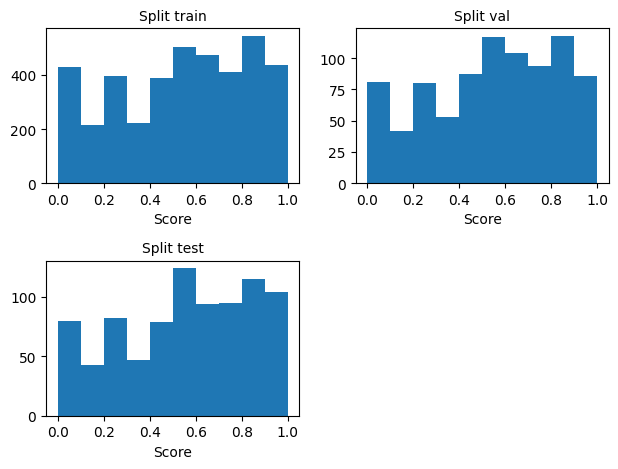

In [ ]:
fig, ax = plt.subplots(2, 2)
plt.subplot(2,2,1)
plt.hist(data_train["score"], bins=10)
plt.xlabel("Score")
plt.title("Split train", {"fontsize":10})

plt.subplot(2,2,2)
plt.hist(data_val["score"], bins=10)
plt.xlabel("Score")
plt.title("Split val", {"fontsize":10})

plt.subplot(2,2,3)
plt.hist(data_test["score"], bins=10)
plt.xlabel("Score")
plt.title("Split test", {"fontsize":10})
fig.tight_layout()
fig.delaxes(ax[1][1])

plt.show()

### Creo lista de InputExample para SentenceTransformer

In [ ]:
# Creo lista de InputExample para SentenceTransformer
train_samples = data_train.apply(lambda x: InputExample(texts=[x['sentence1'], x['sentence2']], label=x["score"]), axis=1).tolist()

In [ ]:
# Creo lista de InputExample para datos de dev
val_samples = data_val.apply(lambda x: InputExample(texts=[x['sentence1'], x['sentence2']], label=x["score"]), axis=1).tolist()

In [ ]:
test_samples = data_test.apply(lambda x: InputExample(texts=[x['sentence1'], x['sentence2']], label=x["score"]), axis=1).tolist()

## Soluciones


In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


### Funciones

In [ ]:
def is_torch_available() :
    try:
        import torch
        return True
    except ImportError:
        return False

def set_seed(seed: int):
    """
    Modified from : https://github.com/huggingface/transformers/blob/master/src/transformers/trainer_utils.py
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).
    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if is_torch_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available

        ## From https://pytorch.org/docs/stable/notes/randomness.html
        torch.backends.cudnn.benchmark = False

        ## Might want to use the following, but set CUBLAS_WORKSPACE_CONFIG=:16:8
        # try :
        #   torch.use_deterministic_algorithms(True)
        # except AttributeError:
        #   torch.set_deterministic( True )

Código tomado de la notebook [Baseline and Preprocessing](https://colab.research.google.com/drive/1tueU02XwM4Ze1B6t-GPx6IIkeTTFjJOA?usp=sharing) ofrecida por SemEval.

In [ ]:
# Función tomada de la notebook baseline. Modificar para hacer mas eficiente
def prepare_eval_data( location, languages, test_print=False ) :
  header, data = load_csv( location )
  sentence1s = list()
  sentence2s = list()
  for elem in data :
    if not languages is None and not elem[ header.index( 'Language' ) ] in languages :
      continue
    sentence1 = elem[ header.index( 'sentence1' ) ]
    sentence2 = elem[ header.index( 'sentence2' ) ]
    mwe1      = elem[ header.index( 'MWE1'      ) ]
    mwe2      = elem[ header.index( 'MWE2'      ) ]

    if test_print :
      print( sentence1 )
      print( sentence2 )
      print( mwe1 )
      print( mwe2 )

    if mwe1 != 'None' :
      replaced = re.sub( mwe1, tokenise_idiom( mwe1 ), sentence1, flags=re.I)
      assert replaced != sentence1
      sentence1 = replaced
    if mwe2 != 'None' :
      replaced = re.sub( mwe1, tokenise_idiom( mwe2 ), sentence2, flags=re.I)
      assert replaced != sentence2
      sentence2 = replaced

    if test_print :
      print( sentence1 )
      print( sentence2 )
      break

    sentence1s.append( sentence1 )
    sentence2s.append( sentence2 )

  return sentence1s, sentence2s

def get_similarities( location, model, languages=None ) :
  sentences1, sentences2 = prepare_eval_data( location, languages )

  #Compute embedding for both lists
  embeddings1 = model.encode(sentences1, show_progress_bar=True, convert_to_numpy=True)
  embeddings2 = model.encode(sentences2, show_progress_bar=True, convert_to_numpy=True)

  # Compute cosine-similarits
  cosine_scores = 1 - (paired_cosine_distances(embeddings1, embeddings2))

  return cosine_scores

In [ ]:
def load_csv( path ) :
  header = None
  data   = list()
  with open( path, encoding='utf-8') as csvfile:
    reader = csv.reader( csvfile )
    for row in reader :
      if header is None :
        header = row
        continue
      data.append( row )
  return header, data

In [ ]:
def write_csv( data, location ) :
  with open( location, 'w', encoding='utf-8') as csvfile:
    writer = csv.writer( csvfile )
    writer.writerows( data )
  print( "Wrote {}".format( location ) )
  return

In [ ]:
def insert_to_submission( languages, settings, sims, location ) :
  header, data = load_csv( location )
  sims = list( reversed( sims ) )
  ## Validate with length
  updatable = [ i for i in data if i[ header.index( 'Language' ) ] in languages and i[ header.index( 'Setting' ) ] in settings ]
  assert len( updatable ) == len( sims )

  ## Will update in sequence - if data is not in sequence must update one language / setting at a time.
  started_update = False
  for elem in data :
    if elem[ header.index( 'Language' ) ] in languages and elem[ header.index( 'Setting' ) ] in settings :
      sim_to_insert = sims.pop()
      elem[-1] = sim_to_insert
      started_update = True
    else :
      assert not started_update ## Once we start, we must complete.
    if len( sims ) == 0 :
      break
  assert len( sims ) == 0 ## Should be done here.

  return [ header ] + data ## Submission file must retain header.

In [ ]:
def evaluar_resultados(sim_scores, file_format_location, setting, languages, res_location, labels_location):
  submission_data = insert_to_submission(languages, setting, sim_scores, file_format_location)

  write_csv(submission_data, res_location)

  ## Evaluate
  results = evaluate_submission(res_location, labels_location)
  return results

In [ ]:
def tokenise_idiom( phrase ) :
  return 'ID' + re.sub( r'[\s|-]', '', phrase ).lower() + 'ID'

In [ ]:
seed = 4
set_seed(seed)

### Paths

In [ ]:
# Path para leer modelo ya entrenado
model_path = f"/content/drive/MyDrive/proyecto-final-ecd/model-task-b/tokenizedSentTransNoPreTrain_{str(seed)}"

data_location = "/content/drive/MyDrive/proyecto-final-ecd/datasets/subtask-b/"

# Create submission file on the development set.
labels_location_dev = os.path.join(data_location, 'dev.gold.csv')
dev_location = os.path.join(data_location, 'dev.csv')
dev_formated_file_location = os.path.join(data_location, 'dev.submission_format.csv')
results_file_dev = os.path.join("model-task-b", 'dev.pre_train_results-'+str(seed)+'.csv')

# Create submission file on the eval set.
eval_location = os.path.join(data_location, 'eval.csv')
eval_formated_file_location = os.path.join(data_location, 'eval.submission_format.csv')
results_file_eval = os.path.join( "model-task-b", 'eval.pre_train_results-' + str( seed ) + '.csv' )

# Create submission file on the test set.
test_location = os.path.join(data_location, 'test.csv')
test_formated_file_location = os.path.join(data_location, 'test.submission_format.csv')
results_file_test = os.path.join("model-task-b", 'test.pre_train_results-' + str( seed ) + '.csv' )

## Baseline: Modelo pre entrenado sin fine-tune

In [ ]:
dev_data.head()

,ID,Language,MWE1,MWE2,sentence1,sentence2,sim
0,83910,EN,high life,None,Are these interruptions of the good life a nec...,Are these interruptions of the good life a nec...,1.0
1,14692,EN,high life,None,But for Australian fashion designer Abby Kheir...,But for Australian fashion designer Abby Kheir...,1.0
2,3378,EN,high life,None,"With that, I will be enjoying the pleasures of...","With that, I will be enjoying the pleasures of...",1.0
3,97296,EN,high life,None,"Fendi offered swaddling, belted coats resembli...","Fendi offered swaddling, belted coats resembli...",1.0
4,36148,EN,high life,None,"Rick Ross and Diddy exemplify the high life, t...",Rick Ross and Diddy exemplify the expensive li...,1.0


### bert-base-cased sin fine-tune

In [ ]:
word_embedding_model = models.Transformer('bert-base-cased')
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),
                                pooling_mode_mean_tokens=True,
                                pooling_mode_cls_token=False,
                                pooling_mode_max_tokens=False)

tokenizer = AutoTokenizer.from_pretrained('bert-base-cased', use_fast=False, truncation=True)
model_baseline2 = SentenceTransformer(modules=[word_embedding_model, pooling_model])
model_baseline2._first_module().tokenizer = tokenizer

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
dev_sims_baseline  = get_similarities("/content/drive/MyDrive/proyecto-final-ecd/datasets/subtask-b/dev.csv", model_baseline2, ["EN"])

Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Batches:   0%|          | 0/35 [00:00<?, ?it/s]

In [ ]:
results_file_b2 = os.path.join("/content/drive/MyDrive/proyecto-final-ecd/model-task-b-results", 'dev.pre_train_results_baseline2-'+str(seed)+'.csv')
results = evaluar_resultados(dev_sims_baseline, dev_formated_file_location, ['pre_train'], ["EN"], results_file_b2, labels_location_dev)
## Make results printable.
for result in results :
  for result_index in range( 2, 5 ) :
    result[result_index] = 'Did Not Attempt' if result[result_index] is None else result[ result_index ]
%reload_ext google.colab.data_table
import pandas as pd
df = pd.DataFrame(data=results[1:], columns=results[0])

df

Wrote /content/drive/MyDrive/proyecto-final-ecd/model-task-b-results/dev.pre_train_results_baseline2-4.csv


,Settings,Languages,Spearman Rank ALL,Spearman Rank Idiom Data,Spearman Rank STS Data
0,pre_train,EN,0.697319,0.108656,0.646743
1,pre_train,PT,Did Not Attempt,Did Not Attempt,Did Not Attempt
2,pre_train,"EN,PT",Did Not Attempt,Did Not Attempt,Did Not Attempt
3,fine_tune,EN,Did Not Attempt,Did Not Attempt,Did Not Attempt
4,fine_tune,PT,Did Not Attempt,Did Not Attempt,Did Not Attempt
5,fine_tune,"EN,PT",Did Not Attempt,Did Not Attempt,Did Not Attempt


### all-MiniLM-L6-v2 sin fine-tune



In [ ]:
# Modelo para STS
model_baseline = SentenceTransformer('all-MiniLM-L6-v2')

dev_sims_baseline  = get_similarities("/content/drive/MyDrive/proyecto-final-ecd/datasets/subtask-b/dev.csv", model_baseline, ["EN"])


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Batches:   0%|          | 0/35 [00:00<?, ?it/s]

In [ ]:
results_file_b = os.path.join("model-task-b", 'dev.pre_train_results_baseline-'+str(seed)+'.csv')
results = evaluar_resultados(dev_sims_baseline, dev_formated_file_location, ['pre_train'], ["EN"], results_file_b, labels_location_dev)
## Make results printable.
for result in results :
  for result_index in range( 2, 5 ) :
    result[result_index] = 'Did Not Attempt' if result[result_index] is None else result[ result_index ]
%reload_ext google.colab.data_table
import pandas as pd
df = pd.DataFrame(data=results[1:], columns=results[0])

df

Wrote model-task-b/dev.pre_train_results-4.csv


,Settings,Languages,Spearman Rank ALL,Spearman Rank Idiom Data,Spearman Rank STS Data
0,pre_train,EN,0.724071,0.269254,0.855163
1,pre_train,PT,Did Not Attempt,Did Not Attempt,Did Not Attempt
2,pre_train,"EN,PT",Did Not Attempt,Did Not Attempt,Did Not Attempt
3,fine_tune,EN,Did Not Attempt,Did Not Attempt,Did Not Attempt
4,fine_tune,PT,Did Not Attempt,Did Not Attempt,Did Not Attempt
5,fine_tune,"EN,PT",Did Not Attempt,Did Not Attempt,Did Not Attempt


### all-MiniLM-L6-v2 con fine-tune

In [ ]:
model_baseline3 = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:
train_batch_size = 4
num_epochs = 4

train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=train_batch_size)
train_loss = losses.CosineSimilarityLoss(model=model_baseline3)
evaluator = EmbeddingSimilarityEvaluator.from_input_examples(val_samples, name='sts-dev')

In [ ]:
model_baseline3_path = f"/content/drive/MyDrive/proyecto-final-ecd/model-task-b/tokenizedSentTransNoPreTrain_{str(seed)}_b3"

model_baseline3.fit(train_objectives=[(train_dataloader, train_loss)],
                    epochs=num_epochs,
                    evaluator=evaluator,
                    evaluation_steps=100,
                    output_path=model_baseline3_path)


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1006 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1006 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1006 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1006 [00:00<?, ?it/s]

In [ ]:
test_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(test_samples, name='sts-test')
res = test_evaluator(model_baseline3, output_path=model_baseline3_path)
print(f"Spearman rank correlation: {res}")

Resultado evaluator: 0.8631778228814666


In [ ]:
sims_b3  = get_similarities("/content/drive/MyDrive/proyecto-final-ecd/datasets/subtask-b/dev.csv", model_baseline3, ["EN"])

Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Batches:   0%|          | 0/35 [00:00<?, ?it/s]

In [ ]:
# Evaluate development set.
results_file_b3 = os.path.join("/content/drive/MyDrive/proyecto-final-ecd/model-task-b-results", 'dev.pre_train_results_baseline3-'+str(seed)+'.csv')
results = evaluar_resultados(sims_b3, dev_formated_file_location, ['pre_train'], ["EN"], results_file_b3, labels_location_dev)
# Print de resultados
for result in results :
  for result_index in range( 2, 5 ) :
    result[result_index] = 'Did Not Attempt' if result[result_index] is None else result[ result_index ]
%reload_ext google.colab.data_table
import pandas as pd
df = pd.DataFrame(data=results[1:], columns=results[0])

df

Wrote /content/drive/MyDrive/proyecto-final-ecd/model-task-b-results/dev.pre_train_results_baseline3-4.csv


,Settings,Languages,Spearman Rank ALL,Spearman Rank Idiom Data,Spearman Rank STS Data
0,pre_train,EN,0.772184,0.273503,0.891562
1,pre_train,PT,Did Not Attempt,Did Not Attempt,Did Not Attempt
2,pre_train,"EN,PT",Did Not Attempt,Did Not Attempt,Did Not Attempt
3,fine_tune,EN,Did Not Attempt,Did Not Attempt,Did Not Attempt
4,fine_tune,PT,Did Not Attempt,Did Not Attempt,Did Not Attempt
5,fine_tune,"EN,PT",Did Not Attempt,Did Not Attempt,Did Not Attempt


### bert-base-cased con fine-tune

In [ ]:
model_baseline4 = SentenceTransformer('bert-base-cased')

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
train_batch_size = 4
num_epochs = 4

train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=train_batch_size)
train_loss = losses.CosineSimilarityLoss(model=model_baseline4)
evaluator = EmbeddingSimilarityEvaluator.from_input_examples(val_samples, name='sts-dev')

In [ ]:
model_baseline4_path = f"/content/drive/MyDrive/proyecto-final-ecd/model-task-b/tokenizedSentTransNoPreTrain_{str(seed)}_b4"

model_baseline4.fit(train_objectives=[(train_dataloader, train_loss)],
                    epochs=num_epochs,
                    evaluator=evaluator,
                    evaluation_steps=100,
                    output_path=model_baseline4_path)


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1006 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1006 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1006 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1006 [00:00<?, ?it/s]

In [ ]:
test_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(test_samples, name='sts-test')
res = test_evaluator(model_baseline4, output_path=model_baseline4_path)
print(f"Spearman rank correlation: {res}")

Spearman rank correlation: 0.831594838902462


In [ ]:
sims_b4  = get_similarities("/content/drive/MyDrive/proyecto-final-ecd/datasets/subtask-b/dev.csv", model_baseline4, ["EN"])

Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Batches:   0%|          | 0/35 [00:00<?, ?it/s]

In [ ]:
# Evaluate development set.
results_file_b4 = os.path.join("/content/drive/MyDrive/proyecto-final-ecd/model-task-b-results", 'dev.pre_train_results_baseline4-'+str(seed)+'.csv')
results = evaluar_resultados(sims_b4, dev_formated_file_location, ['pre_train'], ["EN"], results_file_b4, labels_location_dev)
# Print de resultados
for result in results :
  for result_index in range( 2, 5 ) :
    result[result_index] = 'Did Not Attempt' if result[result_index] is None else result[ result_index ]
%reload_ext google.colab.data_table
import pandas as pd
df = pd.DataFrame(data=results[1:], columns=results[0])

df

Wrote /content/drive/MyDrive/proyecto-final-ecd/model-task-b-results/dev.pre_train_results_baseline4-4.csv


,Settings,Languages,Spearman Rank ALL,Spearman Rank Idiom Data,Spearman Rank STS Data
0,pre_train,EN,0.731634,0.21364,0.850997
1,pre_train,PT,Did Not Attempt,Did Not Attempt,Did Not Attempt
2,pre_train,"EN,PT",Did Not Attempt,Did Not Attempt,Did Not Attempt
3,fine_tune,EN,Did Not Attempt,Did Not Attempt,Did Not Attempt
4,fine_tune,PT,Did Not Attempt,Did Not Attempt,Did Not Attempt
5,fine_tune,"EN,PT",Did Not Attempt,Did Not Attempt,Did Not Attempt


## Pre-train setting

### Extraer idioms para agregarlos al tokenizer

In [ ]:
seed = 4
set_seed(seed)

In [ ]:
# Utilizo idioms de los datos de de dev y eval para agregarlos al vocabulario como tokens
idioms = pd.concat([dev_data["MWE1"], eval["MWE1"], dev_data["MWE2"], eval["MWE2"]], axis=0)
idioms.drop_duplicates(inplace=True)
idioms = idioms.to_list()
print(f"Total de Idioms encontrados: {len(idioms)}")

# Tokenizo idioms
idioms = [tokenise_idiom(i) for i in idioms]

Total de Idioms encontrados: 61


### Descargar y tokenizar modelo

In [ ]:
model = AutoModelForMaskedLM.from_pretrained('bert-base-cased')
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased', use_fast=False, truncation=True)

# Agrego tokens al tokenizador
old_len = len(tokenizer)
num_added_toks = tokenizer.add_tokens(idioms)
print( "Longitud del tokenizer original: {}. Se agregaron {} nuevos tokens. La nueva longitud es {}.".format(old_len, num_added_toks, len(tokenizer)))
model.resize_token_embeddings(len(tokenizer))

model.save_pretrained(f"model_task_b-{str(seed)}")
tokenizer.save_pretrained(f"model_task_b-{str(seed)}")

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Longitud del tokenizer original: 28996. Se agregaron 61 nuevos tokens. La nueva longitud es 29057.


('model_task_b-4/tokenizer_config.json',
 'model_task_b-4/special_tokens_map.json',
 'model_task_b-4/vocab.txt',
 'model_task_b-4/added_tokens.json')

### Crear Sentence Transformers Model
Uso el dataset de [STSBenchmark](https://ixa2.si.ehu.eus/stswiki/index.php/STSbenchmark) para Inglés (solo el split de train).

### Entreno Tokenized Sentence Transformer Model

In [ ]:
word_embedding_model = models.Transformer(f"model_task_b-{str(seed)}")

# Aplico mean pooling para obtener un vector de oración de tamaño fijo
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),
                                pooling_mode_mean_tokens=True,
                                pooling_mode_cls_token=False,
                                pooling_mode_max_tokens=False)

# Uso tokenizer con los idioms
tokenizer = AutoTokenizer.from_pretrained(f"model_task_b-{str(seed)}", use_fast = False, max_length = 510, force_download = True)

model = SentenceTransformer(modules=[word_embedding_model, pooling_model])
model._first_module().tokenizer = tokenizer

model.save(f"tokenizedSentTrans_{str(seed)}")

Some weights of the model checkpoint at model_task_b-4 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at model_task_b-4 and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should pr

In [ ]:
# Probar modificando a 16?
train_batch_size = 4
num_epochs = 4

train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=train_batch_size)
train_loss = losses.CosineSimilarityLoss(model=model)

evaluator = EmbeddingSimilarityEvaluator.from_input_examples(val_samples, name='sts-dev')

# Configuro el entrenamiento
warmup_steps = math.ceil(len(train_dataloader)*num_epochs*0.1) # 10% de datos de train para warm-up
print("Warmup-steps: {}".format(warmup_steps), flush=True)

# Entreno el modelo

model.fit(train_objectives=[(train_dataloader, train_loss)],
        evaluator=evaluator,
        epochs=num_epochs,
        evaluation_steps=1000,
        warmup_steps=warmup_steps,
        save_best_model=True,
        output_path=f"tokenizedSentTransNoPreTrain_{str(seed)}"
)



Warmup-steps: 403


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1006 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1006 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1006 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1006 [00:00<?, ?it/s]

#### Spearman and Pearson rank correlation. Metric: cosine similarity

In [ ]:
test_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(test_samples, name='sts-test')
res = test_evaluator(model, output_path=f"tokenizedSentTransNoPreTrain_{str(seed)}")
print(f"Resultado evaluator: {res}")

Resultado evaluator: 0.822905545109978


In [ ]:
## Save en drive
!mkdir -p /content/drive/MyDrive/proyecto-final-ecd/model-task-b/tokenizedSentTransNoPreTrain/
!cp -r /content/tokenizedSentTransNoPreTrain_4/* /content/drive/MyDrive/proyecto-final-ecd/model-task-b/tokenizedSentTransNoPreTrain/

## Genero submission File and Evaluate

In [ ]:
# Path para leer modelo ya entrenado
model_path = f"/content/drive/MyDrive/proyecto-final-ecd/model-task-b/tokenizedSentTransNoPreTrain_{str(seed)}"
model = SentenceTransformer(model_path)

In [ ]:
dev_sims  = get_similarities("/content/drive/MyDrive/proyecto-final-ecd/datasets/subtask-b/dev.csv", model, ["EN"])


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Batches:   0%|          | 0/35 [00:00<?, ?it/s]

In [ ]:
# Evaluate development set.
results = evaluar_resultados(dev_sims, dev_formated_file_location, ['pre_train'], ["EN"], results_file_dev, labels_location_dev)
# Print de resultados
for result in results :
  for result_index in range( 2, 5 ) :
    result[result_index] = 'Did Not Attempt' if result[result_index] is None else result[ result_index ]
%reload_ext google.colab.data_table
import pandas as pd
df = pd.DataFrame(data=results[1:], columns=results[0])

df

Wrote model-task-b/dev.pre_train_results-4.csv


,Settings,Languages,Spearman Rank ALL,Spearman Rank Idiom Data,Spearman Rank STS Data
0,pre_train,EN,0.785114,0.262509,0.866311
1,pre_train,PT,Did Not Attempt,Did Not Attempt,Did Not Attempt
2,pre_train,"EN,PT",Did Not Attempt,Did Not Attempt,Did Not Attempt
3,fine_tune,EN,Did Not Attempt,Did Not Attempt,Did Not Attempt
4,fine_tune,PT,Did Not Attempt,Did Not Attempt,Did Not Attempt
5,fine_tune,"EN,PT",Did Not Attempt,Did Not Attempt,Did Not Attempt


In [ ]:
# Para descargar archivo de resultados
# from google.colab import files
# files.download('model-task-b/dev.pre_train_results-4.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Output para evaluation set

In [ ]:
eval_sims = get_similarities("/content/drive/MyDrive/proyecto-final-ecd/datasets/subtask-b/eval.csv", model, ["EN"])

Batches:   0%|          | 0/37 [00:00<?, ?it/s]

Batches:   0%|          | 0/37 [00:00<?, ?it/s]

In [ ]:
submission_data = insert_to_submission(["EN"], [ 'pre_train' ], eval_sims, eval_formated_file_location)
# No tengo labels, se guarda el archivo para subir a CodaLab
write_csv(submission_data, results_file_eval)

Wrote model-task-b/eval.pre_train_results-4.csv


In [ ]:
from google.colab import files
files.download('model-task-b/eval.pre_train_results-4.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Save
!cp /content/models/RESULTS_TABLE-eval.pre_train_4.csv /content/gdrive/MyDrive/proyecto-final-ecd/model-task-b/tokenizedSentTransNoPreTrain/

#### Output para test-set SemEval

In [ ]:
test_sims = get_similarities("/content/drive/MyDrive/proyecto-final-ecd/datasets/subtask-b/test.csv", model, ["EN"])

Batches:   0%|          | 0/81 [00:00<?, ?it/s]

Batches:   0%|          | 0/81 [00:00<?, ?it/s]

In [ ]:
submission_data = insert_to_submission(["EN"], [ 'pre_train' ], eval_sims, test_formated_file_location)
# No tengo labels, se guarda el archivo para subir a CodaLab
write_csv(submission_data, results_file_test)

Wrote model-task-b/test.pre_train_results-4.csv


In [ ]:
from google.colab import files
files.download('model-task-b/test.pre_train_results-4.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Conclusiones

Para el conjunto de dev se obtuvieron metricas similares al modelo entrenado con el conjunto de train de STS. En este caso considero que usar el modelo pre entrenado es una buena opción que no requiere muchos recursos computacionales. Si se tuviera un conjunto mas grande de entrenamiento tal vez se podrían lograr mejores métricas al entrenar.